# spicy snow counter example

This notebook shows how spicy snow / lievens algorithm might not actually be measuring changes in snow depth as well as we think it does. I hypothesize we are basically accumulating a (elevation dependent) backscatter ratio variability. This elevation dependent backscatter ratio variability is complicated, but likely includes some combination of radar processing affects, radar artifacts, elevation dependent temperature, soil moisture, as well as maybe a little true volume scattering from snow and wet snow effects (ask me about this one, I have some theories), etc. To start testing this hypothesis, I ran the spicy snow algorithm retrieving snow depth over an area that don't actually regularly accumulate snow (mountains just north of phenoix). If I get a similar looking snow depth raster in a mountain range without true snow relative to a snow depth raster from a mountain range with true snow, the physics and physical interpretation of this snow depth method should be in question. I set fake ims data (0 before the accumulation season, 4 in the accumulation season, and 0 afterwards to trick the algorithm into thinking there is snow present during the accumulation season), ran the algorithm, and found a believeable "snow depth". The "snow depth" raster time series is shown below in the facetgrid plot, and below that is the mean "snow depth" in each elevation bin over time.

In [1]:
!pip install -q pystac-client
!pip install -q planetary-computer
!pip install -q odc-stac

In [2]:
import sys
sys.path.append('../../../spicy-snow/')
from spicy_snow.retrieval import retrieve_snow_depth, retrieve_snow_depth_fake_ims 
from spicy_snow.IO.user_dates import get_input_dates
import geopandas as gpd
from pathlib import Path
from shapely import geometry
import contextily as cx 
import matplotlib.pyplot as plt
import xarray as xr
import rioxarray as rxr
import pystac_client
import planetary_computer
import odc.stac
import numpy as np
import pandas as pd

## choose mountainous area with usually no snow during accumulation season

In [3]:
# geojson of aoi
area_gdf = gpd.read_file('data/north_of_pheonix.geojson')
area = list(area_gdf.geometry)[0].envelope # convert feature to box for search

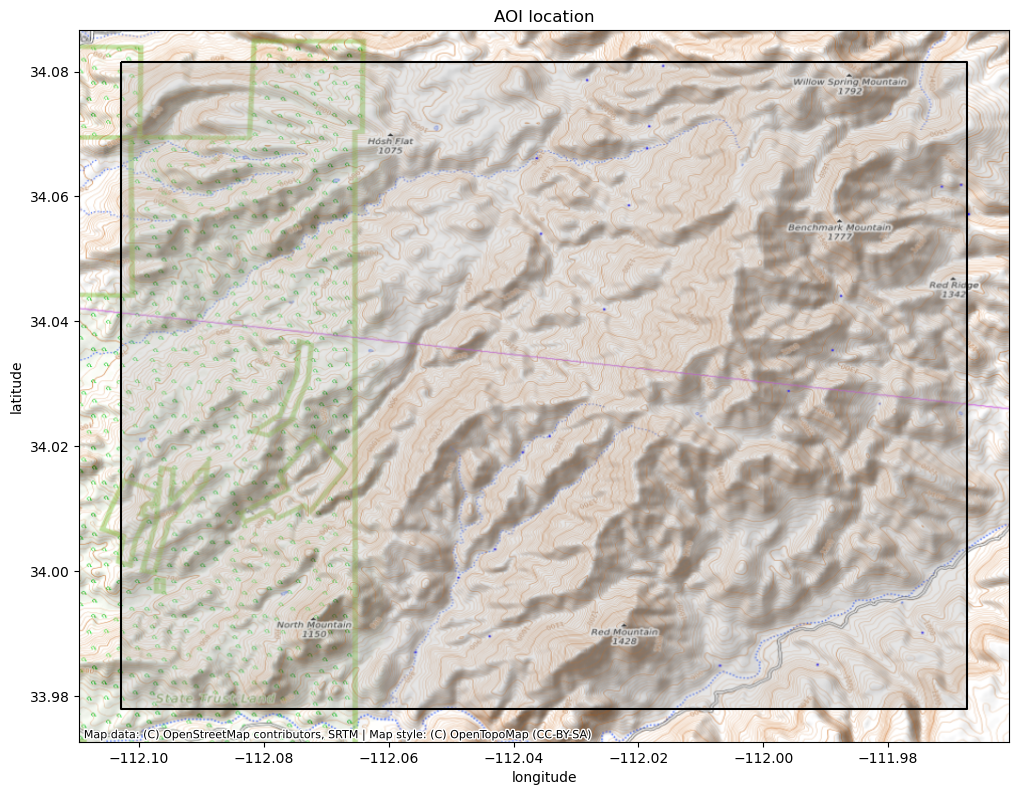

In [4]:
# Plot aoi
fig, ax = plt.subplots(figsize=(12,12))
area_gdf.plot(ax=ax,
              color='darkgrey',
              alpha=0.3)
area_gdf.boundary.plot(ax=ax,
                       color='k')

cx.add_basemap(ax=ax, crs=area_gdf.crs.to_string(), source=cx.providers.OpenTopoMap);
ax.set_xlabel('longitude');
ax.set_ylabel('latitude');
ax.set_title('AOI location');

## retrieve snow depth per usual, except use fake ims data to trick algorithm into thinking snow is present during accumulation season

In [5]:
# # this will generate a tuple of dates from the previous August 1st to this date
# dates = get_input_dates('2021-07-31') # run on all S1 images from 2020-08-01 through 2021-07-31

# # define output directory and file name
# out_nc = Path(f'data/sd_{dates[0]}_{dates[1]}.nc').expanduser()

# spicy_ds = retrieve_snow_depth_fake_ims(area = area, dates = dates, 
#                                work_dir = Path('/tmp/er_test/').expanduser(), 
#                                job_name = f'sd_{dates[0]}_{dates[1]}',
#                                existing_job_name = f'sd_{dates[0]}_{dates[1]}',
#                                debug=False,
#                                outfp=out_nc)

# # the only change in this "fake_ims" function is adding a line after download_snow_cover():
# # ds['ims'] = xr.where((ds['ims'].time<pd.to_datetime('2020-10-15')) | (ds['ims'].time>pd.to_datetime('2021-07-01')) ,0,4)

In [6]:
spicy_ds = xr.open_mfdataset('./data/sd_2020-08-01_2021-07-31.nc')

## "snow depth" raster time series

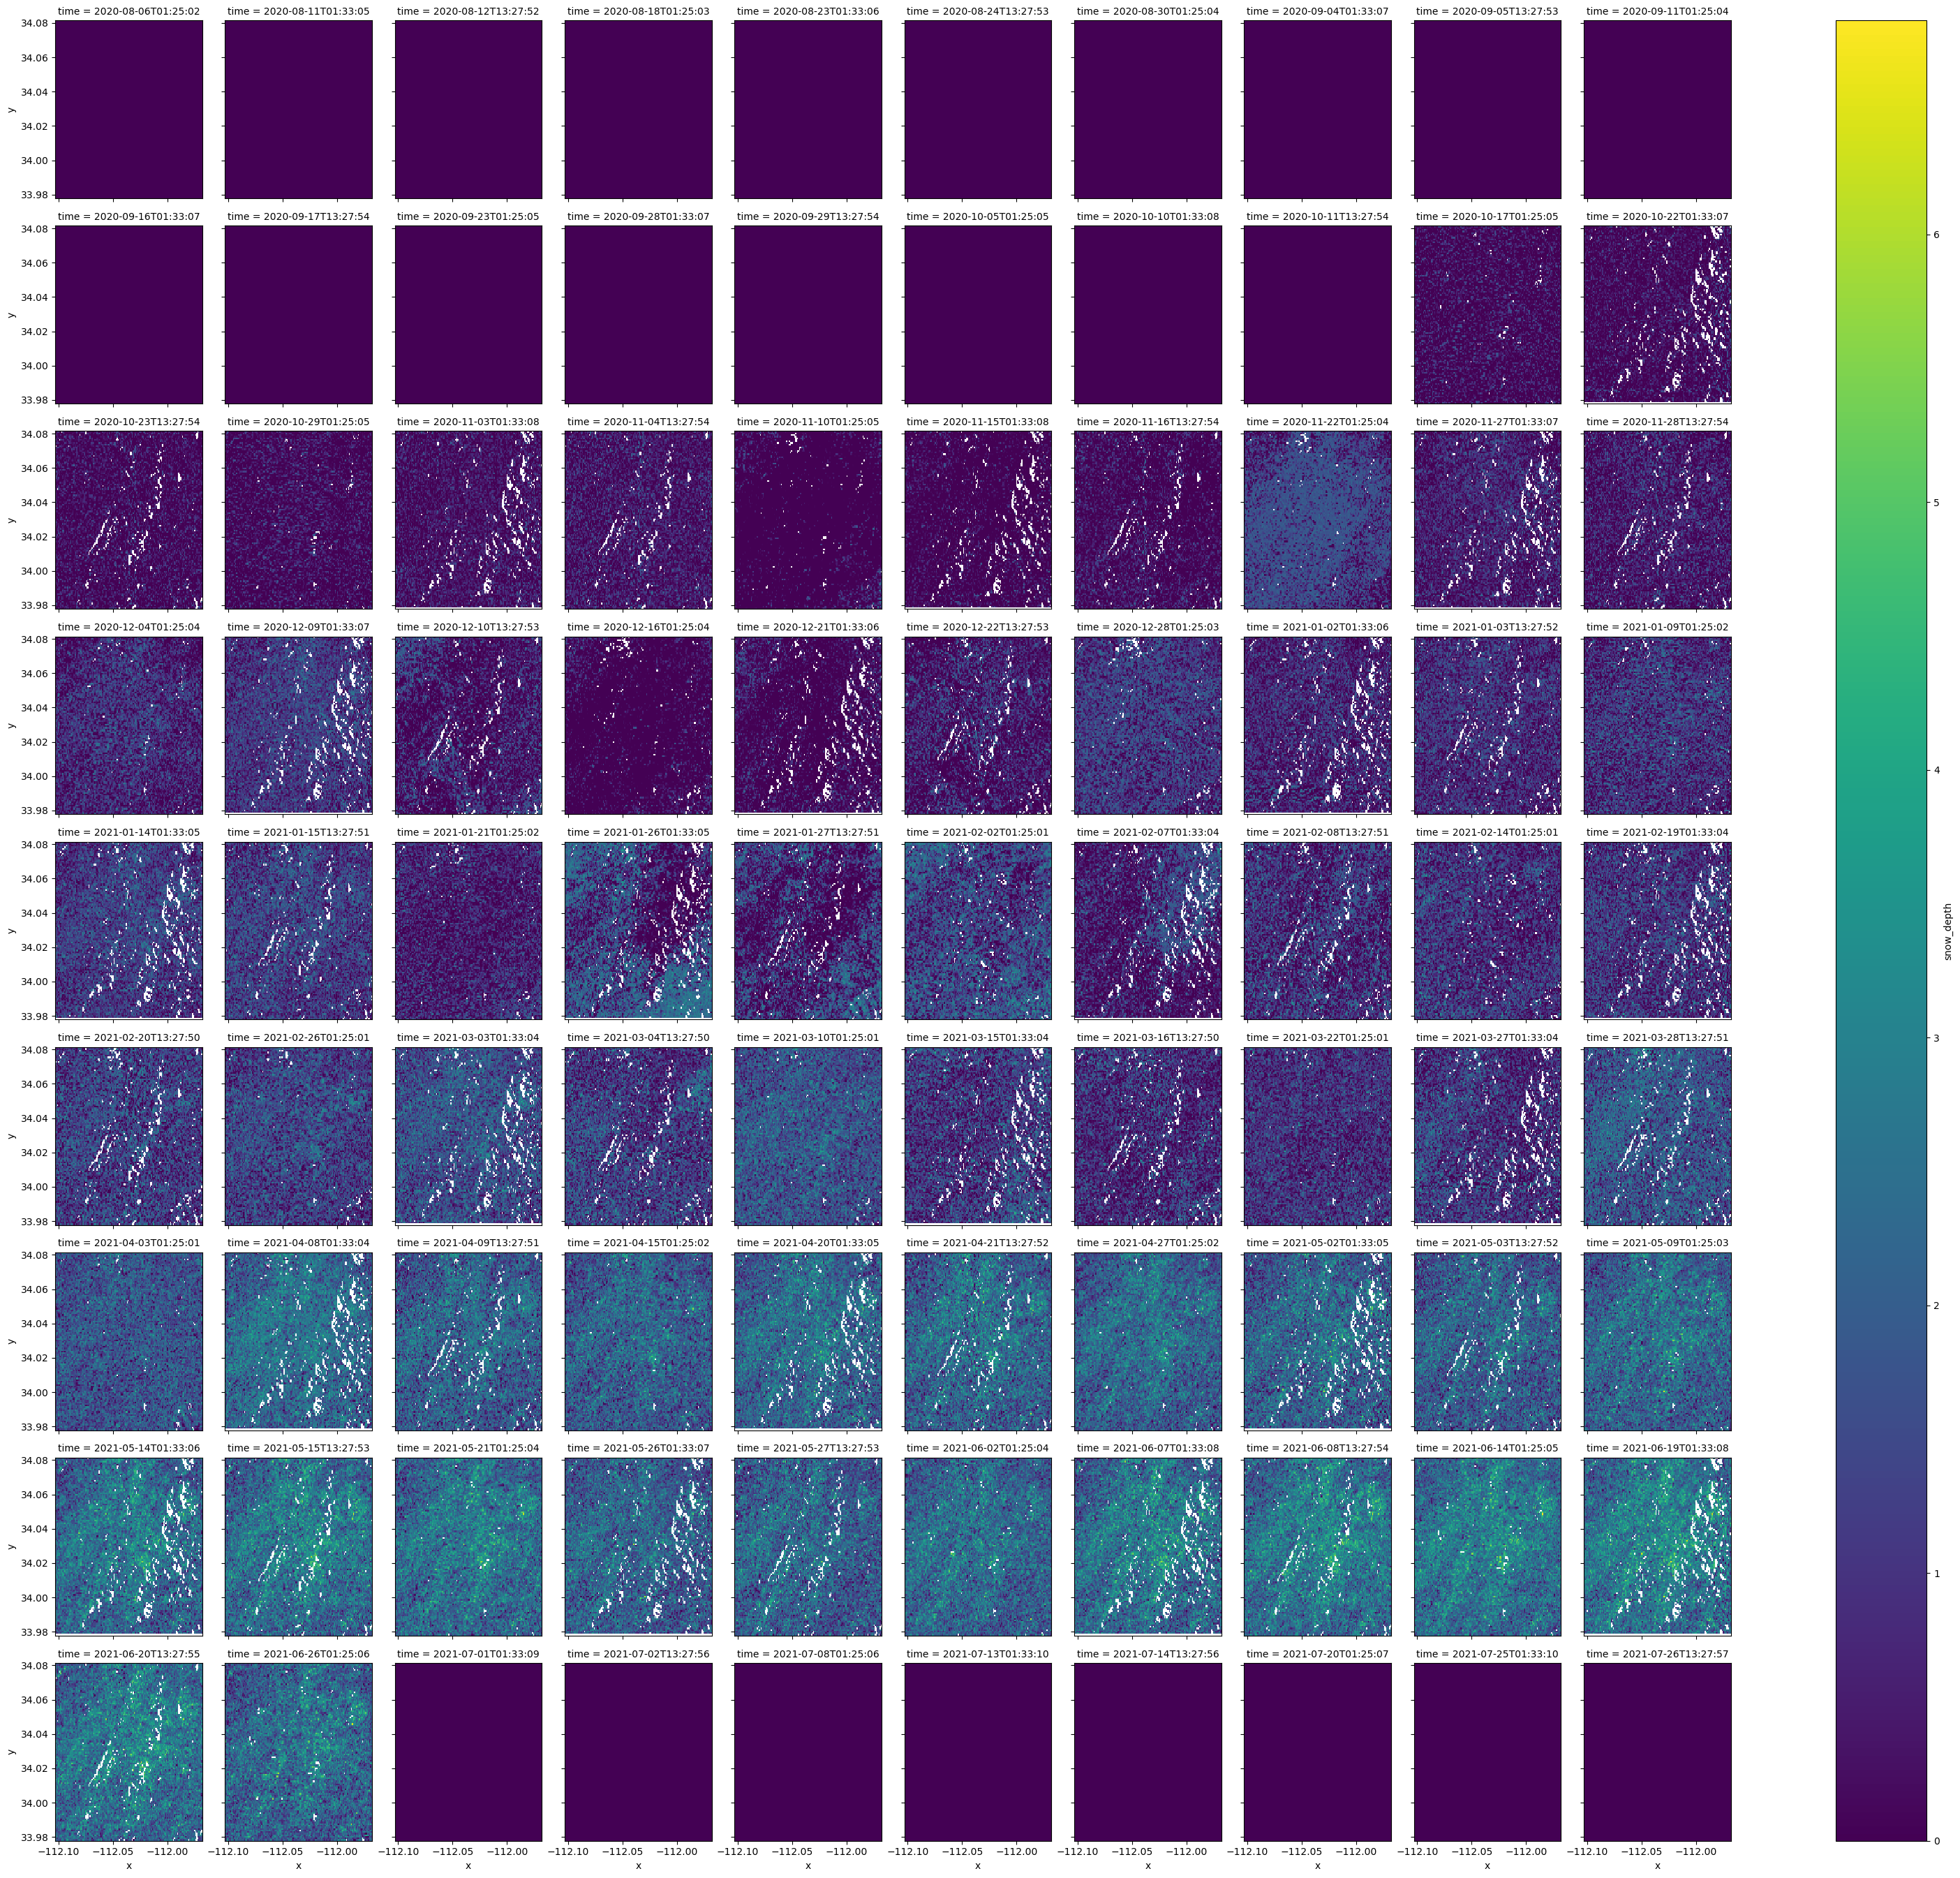

In [7]:
spicy_ds['snow_depth'].plot(col='time',col_wrap=10)

## lets bin the "snow depth" by elevation, take the mean in each bin, and check out the time series

In [10]:
# bring in cop 30 m dem
catalog = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1" ,modifier=planetary_computer.sign_inplace)
search = catalog.search(collections="cop-dem-glo-30", bbox=spicy_ds.rio.bounds())
items = list(search.get_items())

/home/eric/miniconda3/envs/spicy_snow_env/lib/python3.11/site-packages/pystac_client/item_search.py:835: FutureWarning: get_items() is deprecated, use items() instead
  warnings.warn(


In [11]:
dem_raster_all = odc.stac.load(items, bbox=spicy_ds.rio.bounds()).squeeze()
dem_raster = dem_raster_all['data']
dem_raster = dem_raster.rio.set_nodata(np.NaN)

dem = dem_raster.rio.reproject_match(spicy_ds)
spicy_ds['dem'] = dem

<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


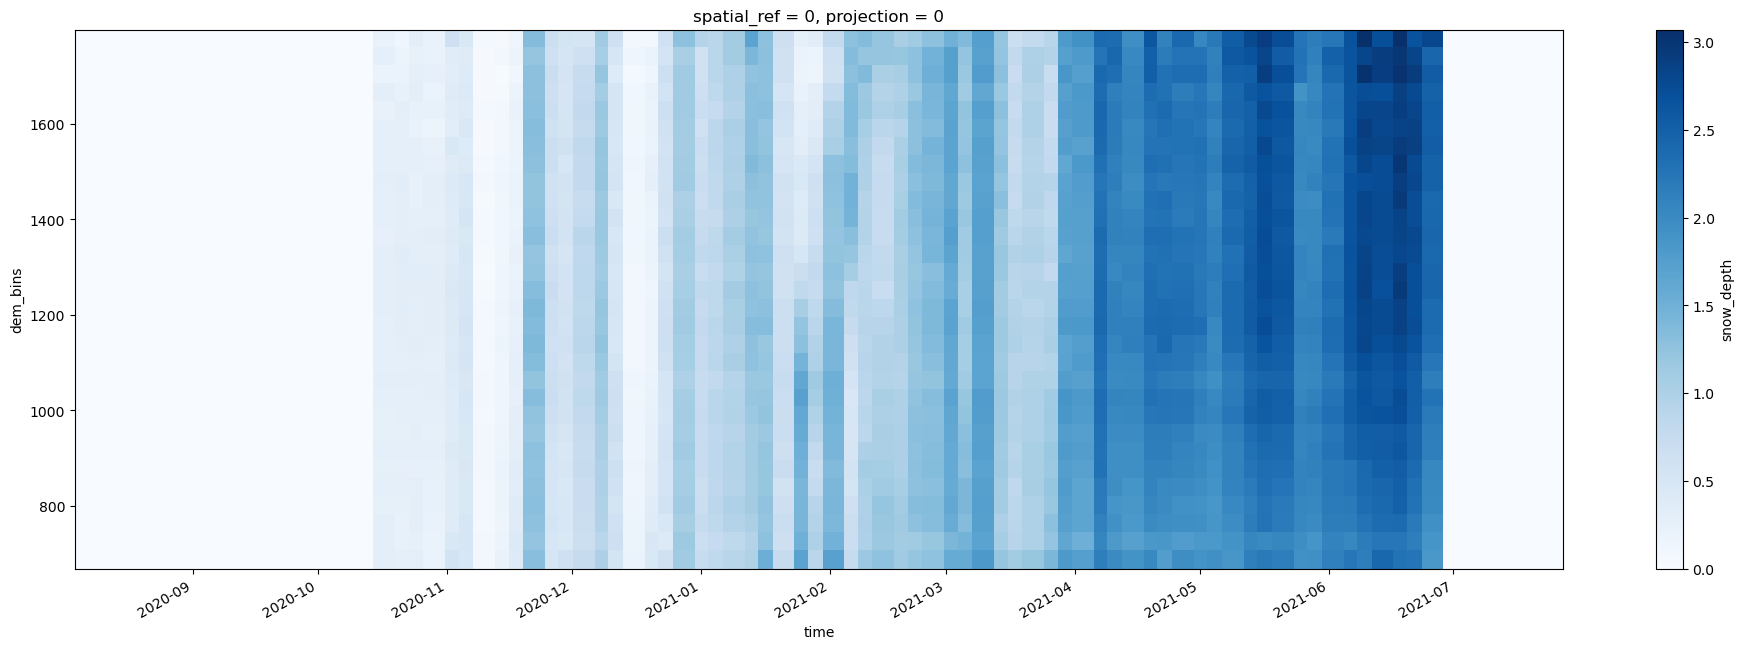

In [12]:
f,ax=plt.subplots(figsize=(24,7))
spicy_ds.groupby_bins(group='dem',bins=30).mean()['snow_depth'].plot(ax=ax,cmap='Blues')
#ax.set_xlim([pd.to_datetime('2020-08-01'),pd.to_datetime('2021-05-01')])